### Demonstration of instructor training

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from disp import set_plot, colors

print('Torch version:', torch.__version__)
print('Cuda available:', torch.cuda.is_available())

device = 'cuda' if  torch.cuda.is_available() else 'cpu'
print('Device:', device)  # tested on cpu and cuda

Torch version: 1.7.1
Cuda available: False
Device: cpu


In [2]:
torch.manual_seed(1337)

# model params
D = 2
N = 2000
TAU = .01
G = 100
DT = .001

J_psi = G*torch.randn((N, D), device=device)
B = torch.eye(D, device=device)
C = torch.eye(D, device=device)

def get_z(x):
    return 1*x

def psi_fn(z):
    return (1+torch.tanh(J_psi@z))*np.sqrt(2/N)

def advance(x, z, w_T, u, L_nz, ml):
    psi = psi_fn(z).reshape((N, 1))
    x_next = x + DT/TAU*(-x + C@w_T@psi + B@u)

    L = L_nz*ml
    w_T_next = w_T + DT*L@psi.T
    return x_next, w_T_next

## Demo of long-range memory using learning rule

In [3]:
# smln params
T = 1.6
IT = int(round(T/DT))
t = np.arange(IT)*DT

# initial conditions
x_0 = torch.tensor([[.001, .001]], device=device).T
w_T_hat_0 = torch.zeros((D, N), device=device)

# inputs
us = torch.zeros((IT, D), device=device)
us[20, 0] = -.05/DT
us[820, 0] = .05/DT

In [4]:
# mask for nonzero learning signals
# IT_L_NZ = torch.tensor([25, 30, 75, 82], device=device)
IT_L_NZ = torch.cat([torch.arange(25, 30, device=device), torch.arange(825, 830, device=device)])
ML = torch.zeros((IT, D), device=device)
ML[IT_L_NZ, :] = 1

In [5]:
# specify loss
MLOSS = torch.zeros((IT, D), device=device)  # mask for loss
MLOSS[[760, 1560], 0] = 1

TARGS = torch.zeros((IT, D), device=device)
TARGS[MLOSS > 0] = torch.tensor([-1., 1.], device=device)

In [6]:
lr = 400
nepoch = 200

def loss_fn(zs):
    return torch.mean(((zs - TARGS)**2)[MLOSS>0])

L_nz = ML.clone().detach()*0
L_nz.requires_grad = True

losses = []
L_nz_save = []
z_hats_save = []

for epoch in range(nepoch):

    x_hats = [x_0.clone()]
    z_hats = [get_z(x_hats[0])]
    w_T_hats = [w_T_hat_0.clone()]

    for ct in range(1, IT):
        x_hat_next, w_T_hat_next = advance(x_hats[-1], z_hats[-1], w_T_hats[-1], us[[ct], :].T, L_nz[[ct], :].T, ML[[ct], :].T)
        z_hat_next = get_z(x_hat_next)

        x_hats.append(x_hat_next)
        z_hats.append(z_hat_next)
        w_T_hats.append(w_T_hat_next)

    x_hats_cc = torch.cat(x_hats, dim=1).T
    z_hats_cc = torch.cat(z_hats, dim=1).T
    w_T_hats_stack = torch.stack(w_T_hats)

    loss = loss_fn(z_hats_cc)
    loss.backward()

    with torch.no_grad():
        L_nz -= lr*L_nz.grad
        L_nz.grad.zero_()

    losses.append(loss.item())

    if epoch == 0 or ((epoch + 1)%50 == 0) or (epoch+1 == nepoch):
        z_hats_save.append(z_hats_cc.clone().detach().numpy())
        L_nz_save.append(L_nz.clone().detach().numpy())

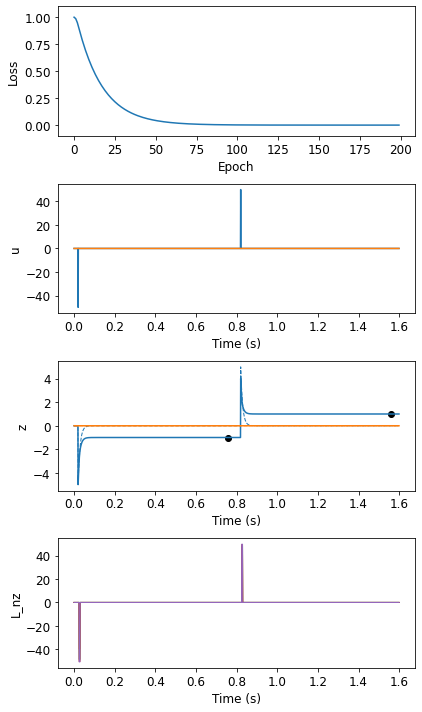

In [8]:
fig, axs = plt.subplots(4, 1, figsize=(6, 10), tight_layout=True)

axs[0].plot(range(nepoch), losses)
set_plot(axs[0], y_lim=(-.1, 1.1), x_label='Epoch', y_label='Loss')

axs[1].plot(t, us)
set_plot(axs[1], x_label='Time (s)', y_label='u')

for d, c in zip(range(D), colors):
    axs[2].plot(t, z_hats_save[0][:, d], c=c, lw=1, ls='--')
    axs[2].plot(t, z_hats_save[-1][:, d], c=c)
    
for itmloss, cmloss in torch.nonzero(MLOSS):
    axs[2].scatter(itmloss*DT, TARGS[itmloss, cmloss], c='k')
    
set_plot(axs[2], x_label='Time (s)', y_label='z')

for L_nz, c in zip(L_nz_save, colors):
    axs[3].plot(t, L_nz, c=c, lw=1)
set_plot(axs[3], x_label='Time (s)', y_label='L_nz')

### Demo of vanishing gradient problem

In [3]:
# smln params
T = 3.2
IT = int(round(T/DT))
t = np.arange(IT)*DT

# initial conditions
x_0 = torch.tensor([[.001, .001]], device=device).T
w_T_hat_0 = torch.zeros((D, N), device=device)

# inputs
us = torch.zeros((IT, D), device=device)
us[20, 0] = -.05/DT
us[820, 0] = .05/DT

us[1620, 0] = -.05/DT
us[2420, 0] = .05/DT

In [4]:
# mask for nonzero learning signals
IT_L_NZ = torch.tensor([25, 825], device=device)
ML = torch.zeros((IT, D), device=device)
ML[IT_L_NZ, :] = 1

## Learning trajectory from sparse loss

In [5]:
# specify loss
MLOSS = torch.zeros((IT, D), device=device)  # mask for loss
MLOSS[[2360, 3160], 0] = 1

TARGS = torch.zeros((IT, D), device=device)
TARGS[MLOSS > 0] = torch.tensor([-1., 1.], device=device)

In [6]:
lr = 400
nepoch = 400

def loss_fn(zs):
    return torch.mean(((zs - TARGS)**2)[MLOSS>0])

L_nz = ML.clone().detach()*0
L_nz.requires_grad = True

losses = []
L_nz_save = []
z_hats_save = []

for epoch in range(nepoch):

    x_hats = [x_0.clone()]
    z_hats = [get_z(x_hats[0])]
    w_T_hats = [w_T_hat_0.clone()]

    for ct in range(1, IT):
        x_hat_next, w_T_hat_next = advance(x_hats[-1], z_hats[-1], w_T_hats[-1], us[[ct], :].T, L_nz[[ct], :].T, ML[[ct], :].T)
        z_hat_next = get_z(x_hat_next)

        x_hats.append(x_hat_next)
        z_hats.append(z_hat_next)
        w_T_hats.append(w_T_hat_next)

    x_hats_cc = torch.cat(x_hats, dim=1).T
    z_hats_cc = torch.cat(z_hats, dim=1).T
    w_T_hats_stack = torch.stack(w_T_hats)

    loss = loss_fn(z_hats_cc)
    loss.backward()

    with torch.no_grad():
        L_nz -= lr*L_nz.grad
        L_nz.grad.zero_()

    losses.append(loss.item())

    if epoch == 0 or ((epoch + 1)%50 == 0) or (epoch+1 == nepoch):
        z_hats_save.append(z_hats_cc.clone().detach().numpy())
        L_nz_save.append(L_nz.clone().detach().numpy())

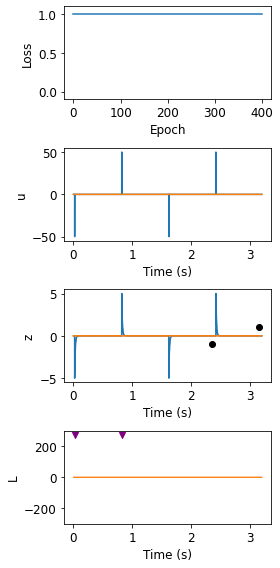

In [13]:
fig, axs = plt.subplots(4, 1, figsize=(4, 8), tight_layout=True)

axs[0].plot(range(nepoch), losses)
set_plot(axs[0], y_lim=(-.1, 1.1), x_label='Epoch', y_label='Loss')

axs[1].plot(t, us)
set_plot(axs[1], x_label='Time (s)', y_label='u')

for d, c in zip(range(D), colors):
    axs[2].plot(t, z_hats_save[0][:, d], c=c, lw=1, ls='--')
    axs[2].plot(t, z_hats_save[-1][:, d], c=c)
    
for itmloss, cmloss in torch.nonzero(MLOSS):
    axs[2].scatter(itmloss*DT, TARGS[itmloss, cmloss], c='k')
    
set_plot(axs[2], x_label='Time (s)', y_label='z')

axs[3].plot(t, L_nz_save[-1], c=c, lw=1)
for it in IT_L_NZ:
    axs[3].scatter(it*DT, 275, marker='v', c='purple')
set_plot(axs[3], y_lim=(-300, 300), x_label='Time (s)', y_label='L')

fig.savefig('ms/4_flip_flop_only_post_learning_eval_demo.svg')

### Demo of solution to vanishing gradient problem

In [3]:
# smln params
T = 3.2
IT = int(round(T/DT))
t = np.arange(IT)*DT

# initial conditions
x_0 = torch.tensor([[.001, .001]], device=device).T
w_T_hat_0 = torch.zeros((D, N), device=device)

# inputs
us = torch.zeros((IT, D), device=device)
us[20, 0] = -.05/DT
us[820, 0] = .05/DT

us[1620, 0] = -.05/DT
us[2420, 0] = .05/DT

In [4]:
# mask for nonzero learning signals
IT_L_NZ = torch.tensor([25, 825], device=device)
ML = torch.zeros((IT, D), device=device)
ML[IT_L_NZ, :] = 1

In [5]:
# specify loss
MLOSS = torch.zeros((IT, D), device=device)  # mask for loss
MLOSS[[760, 1560, 2360, 3160], 0] = 1

TARGS = torch.zeros((IT, D), device=device)
TARGS[MLOSS > 0] = torch.tensor([-1., 1., -1., 1.], device=device)

In [6]:
lr = 400
nepoch = 400

def loss_fn(zs):
    return torch.mean(((zs - TARGS)**2)[MLOSS>0])

L_nz = ML.clone().detach()*0
L_nz.requires_grad = True

losses = []
L_nz_save = []
z_hats_save = []

for epoch in range(nepoch):

    x_hats = [x_0.clone()]
    z_hats = [get_z(x_hats[0])]
    w_T_hats = [w_T_hat_0.clone()]

    for ct in range(1, IT):
        x_hat_next, w_T_hat_next = advance(x_hats[-1], z_hats[-1], w_T_hats[-1], us[[ct], :].T, L_nz[[ct], :].T, ML[[ct], :].T)
        z_hat_next = get_z(x_hat_next)

        x_hats.append(x_hat_next)
        z_hats.append(z_hat_next)
        w_T_hats.append(w_T_hat_next)

    x_hats_cc = torch.cat(x_hats, dim=1).T
    z_hats_cc = torch.cat(z_hats, dim=1).T
    w_T_hats_stack = torch.stack(w_T_hats)

    loss = loss_fn(z_hats_cc)
    loss.backward()

    with torch.no_grad():
        L_nz -= lr*L_nz.grad
        L_nz.grad.zero_()

    losses.append(loss.item())

    if epoch == 0 or ((epoch + 1)%50 == 0) or (epoch+1 == nepoch):
        z_hats_save.append(z_hats_cc.clone().detach().numpy())
        L_nz_save.append(L_nz.clone().detach().numpy())

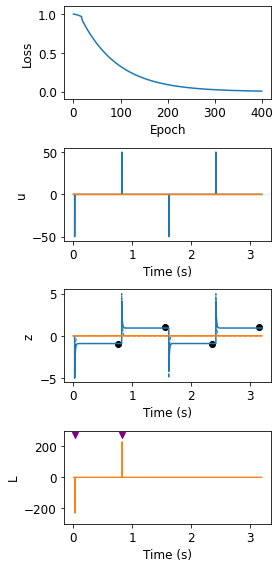

In [18]:
fig, axs = plt.subplots(4, 1, figsize=(4, 8), tight_layout=True)

axs[0].plot(range(nepoch), losses)
set_plot(axs[0], y_lim=(-.1, 1.1), x_label='Epoch', y_label='Loss')

axs[1].plot(t, us)
set_plot(axs[1], x_label='Time (s)', y_label='u')

for d, c in zip(range(D), colors):
    axs[2].plot(t, z_hats_save[0][:, d], c=c, lw=1, ls='--')
    axs[2].plot(t, z_hats_save[-1][:, d], c=c)
    
for itmloss, cmloss in torch.nonzero(MLOSS):
    axs[2].scatter(itmloss*DT, TARGS[itmloss, cmloss], c='k')
    
set_plot(axs[2], x_label='Time (s)', y_label='z')

axs[3].plot(t, L_nz_save[-1], c=c, lw=1)
for it in IT_L_NZ:
    axs[3].scatter(it*DT, 275, marker='v', c='purple')
set_plot(axs[3], y_lim=(-300, 300), x_label='Time (s)', y_label='L')

fig.savefig('ms/4_flip_flop_pre_post_learning_eval_demo.svg')